

```
# Este projeto visa construir um modelo de detecção de sentimento usando SVM (Support Vector Machine) e vetorização TF-IDF (Term Frequency-Inverse Document Frequency).
```





```
# 1 . Baixar o dataset e organizar dentro de um Dataframe Pandas.
  2 . Pré-processar o texto, removendo stopwords, convertendo para minúsculas e realizando a lemmatização.
  3 . Vetorizar o texto usando TF-IDF.
  4 . Treinar um modelo de SVM para classificar os sentimentos.
  5 . Avaliar o desempenho do modelo usando métricas de avaliação.
  6 . Exibir uma matriz de confusão para visualizar os resultados.
  7 . Permitir testes sobre o dataset fornecido pela professora.
```



In [1]:
# Instalações
!pip install nltk

In [2]:
# Imports
# Drive
from google.colab import drive
# pré-processamento de textos utilizando NLTK:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.porter import *

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# Para plotar métricas
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.svm import SVC

import joblib

In [3]:
# Conectando ao google drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 avaliacao_da_disciplina_2022_1.xlsx
 bidirectional.png
 bitcoin_wallet_keywords.png
'Colab Notebooks'
 dataset_professora.csv
 dataset_professora.gsheet
 dataset_professora_predicoes.csv
 links_tcc
'Machine learning techniques for emotion detection and sentiment analysis  current state  challenges  and future directions.pdf'
 modelo_rnn_arthur.keras
 monero_wallet_keywords.png
 olist_customers_dataset.csv
 olist_order_reviews_dataset.csv
 olist_preprocessado.csv
 PLN
 RePro.csv
 repro-main.zip
 ReProRnn.csv
 review_repro_preprocessado.csv
 reviews_ptbr.csv
 tcc_analise_sentimento1.xlsx
 tw_pt.csv


In [4]:
# Lista de stopwords
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Setup input pipeline
Brazilian E-Commerce Public Dataset by Olist
Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

In [5]:
# Como estamos interessados em analisar apenas os textos, vamos selecionar apenas as colunas 'review_text' e 'polarity':

df = pd.read_csv('/content/drive/MyDrive/olist_order_reviews_dataset.csv')
df = df[['review_comment_message', 'review_score']]
labels = []

for score in df['review_score']:
  if score > 3:
    labels.append(1)
  else:
    labels.append(0)

df['Label'] = labels

print(len(df))
df = df.rename(columns={'review_comment_message': 'Texto'})

df = df.dropna(subset=['Texto'])  # remove NaN
df = df[df['Texto'].str.strip() != '']  # remove strings vazias ou só espaços

df = df.reset_index(drop=True)

df.head()

99224


,Texto,review_score,Label
0,Recebi bem antes do prazo estipulado.,5,1
1,Parabéns lojas lannister adorei comprar pela I...,5,1
2,aparelho eficiente. no site a marca do aparelh...,4,1
3,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,1
4,"Vendedor confiável, produto ok e entrega antes...",5,1


In [6]:
print(len(df))

40950


In [7]:
# lista de stopwords em português

stopwords_pt = nltk.corpus.stopwords.words('portuguese')

# Podem ser importantes
stopwords_pt.remove('não')
stopwords_pt.remove('nem')


In [8]:

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stopwords_pt, max_df=0.7)

# Transform the text data to feature vectors
X = vectorizer.fit_transform(df['Texto'])

# Labels
y = df['Label']

In [23]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

# Armazena acurácias para avaliação final
accuracies = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\nFold {i+1}")

    # Divide os dados
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Inicializa e treina o classificador
    clf_kfold = SVC(kernel='linear')
    clf_kfold.fit(X_train, y_train)

    # Faz previsões e avalia
    y_pred = clf_kfold.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"Acurácia do Fold {i+1}: {acc:.2f}")

# Resultado final da validação
print(f"\nAcurácia média após {kf.get_n_splits()} folds: {np.mean(accuracies):.2f}")


Fold 1
Acurácia do Fold 1: 0.92

Fold 2
Acurácia do Fold 2: 0.93

Fold 3
Acurácia do Fold 3: 0.92

Fold 4
Acurácia do Fold 4: 0.92

Fold 5
Acurácia do Fold 5: 0.92

Acurácia média após 5 folds: 0.92


In [9]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [10]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8947


In [24]:
joblib.dump(clf, 'modelo_svm.pkl')
joblib.dump(vectorizer, 'vetorizador.pkl')

['vetorizador.pkl']

In [12]:
def predict_category(text):
    """
    Predict the category of a given text using the trained classifier.
    """
    text_vec = vectorizer.transform([text])
    prediction = clf.predict(text_vec)
    if prediction[0] == 1:
        return 'Positivo'
    else:
        return 'Negativo'

In [13]:
# Example usage
sample_text = ("Particularmente eu não gosto do ensino remoto. Tenho muita dificuldade pra ter foco e algumas aulas chegam a ter aproximadamente, e às vezes ultrapassam, duas horas. É muito tempo para ficar sentado em frente ao computador tendo que absorver o conteúdo. Porém o fato de ter as aulas gravadas e pode assistir posteriormente pra caso tenha perdido a aula ou mesmo para reforçar/revisar o conteúdo é um ponto positivo. As monitorias também ficaram mais &amp;quot;acessíveis&amp;quot; no formato remoto.")
predicted_category = predict_category(sample_text)
print(f'The predicted category is: {predicted_category}')

The predicted category is: Negativo


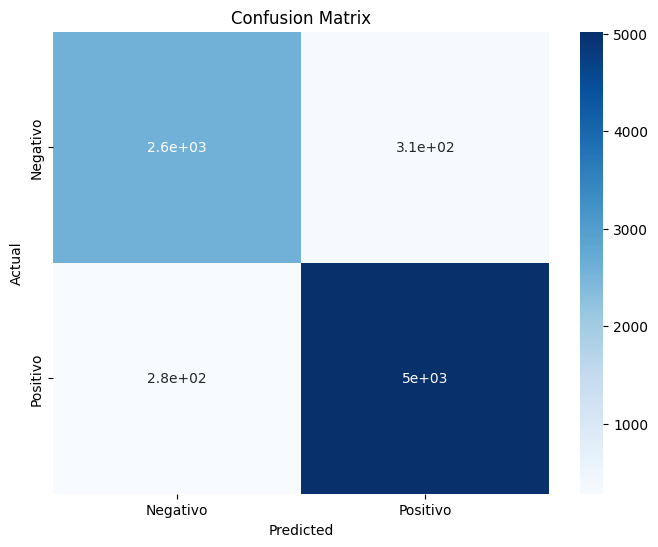

In [14]:
cm = confusion_matrix(y_test, y_pred)
columns = ['Negativo', 'Positivo']
df_cm = pd.DataFrame(cm, index=columns, columns=columns)
plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
# Vamos calcular macro f1 score (Mede o desempenho global considerando igualmente todas as classes, sem levar em conta o desequilíbrio entre elas)
macro_f1_score = f1_score(y_test, y_pred, average='macro')
print("macro_f1_score: " + str(macro_f1_score))
#

macro_f1_score: 0.921377339397966


In [16]:
# macro precision
macro_precision = precision_score(y_test, y_pred, average='macro')
print("macro_precision: " + str(macro_precision))
#

macro_precision: 0.922227466017747


In [17]:
# macro recall
macro_recall = recall_score(y_test, y_pred, average='macro')
print("macro_recall: " + str(macro_recall))

macro_recall: 0.9205493895671477


# Criando dataset de predições

In [25]:
# Carregando o dataset com os dados fornecidos pela professora
dataset_professora = pd.read_csv('/content/drive/MyDrive/dataset_professora.csv')
# Carregamos a coluna de texto das reviews
texto_professora = dataset_professora['feedback']

In [27]:
# Carregar o modelo treinado e o vetorizador
modelo_svm = joblib.load("modelo_svm.pkl")  # Substitua pelo caminho correto do modelo
vectorizer = joblib.load("vetorizador.pkl")  # Substitua pelo caminho correto do vetor de treino

# Transformar os textos com o mesmo TfidfVectorizer
X_novo = vectorizer.transform(texto_professora)

# Fazer as previsões com o modelo treinado
dataset_professora["sentimento_predito"] = modelo_svm.predict(X_novo)

# Substituindo por numéricos para predição
dataset_professora["sentimento_predito"] = dataset_professora["sentimento_predito"].replace([0,1], ["Negativo", "Positivo"])

# Exibir as primeiras linhas para verificar
dataset_professora.head(10)

,semestre,curso,achou_util,feedback,sentimento,sentimento_predito
0,2021.2,Ciência da Computação,SIM,Essa transição de Ensino Médio para Universida...,NaN,Negativo
1,2021.2,Ciência da Computação,SIM,Sinceramente achei bastante cansativo mentalme...,NaN,Positivo
2,2021.2,Licenciatura em Computação (noturno),SIM,"Para ser bem sincero, ainda me sinto um pouco ...",NaN,Positivo
3,2021.2,Ciência da Computação,SIM,O meu primeiro semestre no curso foi bem puxad...,NaN,Positivo
4,2021.2,Ciência da Computação,SIM,Eu já venho de outro curso em outra universida...,NaN,Negativo
5,2021.2,Ciência da Computação,SIM,"Está sendo uma experiência excelente, apesar d...",NaN,Positivo
6,2021.2,Ciência da Computação,SIM,O primeiro semestre para mim foi uma experiênc...,NaN,Positivo
7,2021.2,Ciência da Computação,SIM,"Por ter sido remoto, muito da experiência de s...",NaN,Negativo
8,2021.2,Licenciatura em Computação (noturno),SIM,"Gostei muito desse semestre, apesar de estar i...",NaN,Positivo
9,2021.2,Ciência da Computação,SIM,Apesar de não ter sido meu primeiro semestre c...,NaN,Negativo


In [28]:
dataset_professora.to_csv('dataset_professora_predicoes.csv', index= False, columns= ['semestre', 'curso', 'achou_util', 'feedback', 'sentimento', 'sentimento_predito'])